In [2]:
import numpy as np

import json
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib
%matplotlib inline

plt.style.use('ggplot')
import seaborn as sns

Using matplotlib backend: Qt5Agg


In [3]:
import spacy
nlp = spacy.load('en')

In [1]:
dataset_f = '../data/resolution/processed/'

all_data = []
for x in ['json_train.txt', 'json_dev.txt', 'json_test.txt']:
    data = open(dataset_f + x, 'r').readlines()
    data = [x.strip() for x in data]
    data = [json.loads(x) for x in data]
    all_data += data

In [4]:
dataset = {}
unique_references = []
i = 0
for ex in tqdm(all_data):
    # getting the scene from each group and reindexing inner index in every group
    
    lines_ind = ex['line_indices']
    speakers = ex['speakers']

    tokens = ex['tokens']
    
    anchor = ex['anchors_indices']
    if len(anchor) == 1:
        anchor_words = [tokens[anchor[0]]]
    else:
        anchor_words = tokens[anchor[0]: anchor[-1] + 1]
    anchor_words = [str(x) for x in anchor_words]
    
    head = ex['head']
    refs = []
    if type(head[0]) == int:
        refs = head
        head = 'REFERENCE'
    else:
        head = str(head[0])
    
    dataset[i] = {'tokens': tokens,
                  'num_lines': len(set(lines_ind)), 'num_words': len(tokens),
                        'anchor': anchor_words, 'anchor_ind': anchor[0],
                  'words_in_sentence': Counter(lines_ind).values(),
                 'head': head, 'ref': refs,
                 'line_indices': lines_ind}
    i += 1

100%|██████████| 9412/9412 [00:00<00:00, 13778.79it/s]


# Dataset Statistics

In [5]:
metrics_f = OrderedDict([('min', np.min), ('max', np.max), ('mean', np.mean),
            ('std', np.std), ('median', np.median)])

## General corpus stats

In [6]:
print 'dataset size: {0}'.format(len(dataset))

dataset size: 9412


#### Number of lines in a Scene

In [7]:
scene_lines = [scene['num_lines'] for scene in dataset.values()]
for name, f in metrics_f.iteritems():
    print '{0} number of lines in a scene: {1}'.format(name, f(scene_lines))

min number of lines in a scene: 1
max number of lines in a scene: 28
mean number of lines in a scene: 5.84827879303
std number of lines in a scene: 5.15160451938
median number of lines in a scene: 4.0


#### Words in a Scene

In [8]:
num_words_scene = [scene['num_words'] for scene in dataset.values()]
vals = []
for name, f in metrics_f.iteritems():
    val = f(num_words_scene)
    print '{0} number of words in a scene: {1}'.format(name, val)
    vals.append(val)

min number of words in a scene: 2
max number of words in a scene: 1557
mean number of words in a scene: 95.7051636209
std number of words in a scene: 95.9145805413
median number of words in a scene: 64.0


#### Words in sentence (by speaker)

In [9]:
words_by_speaker = np.hstack([scene['words_in_sentence'] for scene in dataset.values()])
for name, f in metrics_f.iteritems():
    print '{0} number of words in a sentence: {1}'.format(name, f(words_by_speaker))

min number of words in a sentence: 1
max number of words in a sentence: 934
mean number of words in a sentence: 16.3646718988
std number of words in a sentence: 21.082763185
median number of words in a sentence: 11.0


## Target stats

In [10]:
y_dist = Counter([scene['head'] for scene in dataset.values()])

In [11]:
y_dist

Counter({'AGE': 1081,
         'CURRENCY': 386,
         'OTHER': 2208,
         'PEOPLE': 799,
         'REFERENCE': 4237,
         'TIME': 216,
         'YEAR': 485})

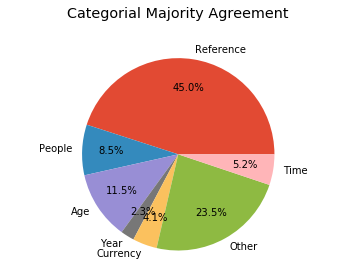

In [12]:
labels = 'Reference', 'People', 'Age', 'Year', 'Currency', 'Other', 'Time'
fig_agg, ax_agg = plt.subplots()

ax_agg.pie(y_dist.values(), labels=labels, autopct='%1.1f%%', pctdistance=0.7)
ax_agg.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Categorial Majority Agreement', y=1.1)
# my_dpi=1200
# plt.savefig('figs/class_dist.png', bbox_inches='tight', format='png', dpi=1200)
plt.show()

In [13]:
num_target_words = [len(scene['anchor']) for scene in dataset.values()]
for name, f in metrics_f.iteritems():
    print '{0} number of anchors in a scene: {1}'.format(name, f(num_target_words))

min number of anchors in a scene: 1
max number of anchors in a scene: 9
mean number of anchors in a scene: 1.04568635784
std number of anchors in a scene: 0.330544963699
median number of anchors in a scene: 1.0


### Target Stats

In [14]:
anchor_words = [x['anchor'] for x in dataset.values()]

In [15]:
target_c = Counter(len(x) for x in anchor_words)
target_w = Counter([' '.join(x) for x in anchor_words])

#### Target Lengths

In [16]:
target_c

Counter({1: 9153, 2: 153, 3: 78, 4: 8, 5: 13, 6: 3, 7: 1, 9: 3})

#### Most common target words

In [17]:
def bar_plot(objects, vals, y_pos, title, x_label, y_label):
    plt.bar(y_pos, vals, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

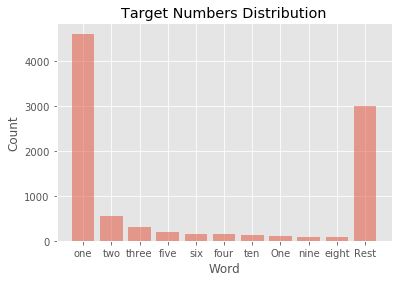

In [18]:
targets = target_w.most_common(n=10)
target_least_common = sum([x[1] for x in reversed(target_w.most_common()[-(len(target_w) - len(targets)):])])

words_vals = [t[1] for t in targets] + [target_least_common]
words = [t[0] for t in targets] + ['Rest']
y_pos = np.arange(len(words_vals))
bar_plot(words, words_vals, y_pos, 'Target Numbers Distribution', 'Word', 'Count')

In [19]:
targets

[('one', 4616),
 ('two', 558),
 ('three', 307),
 ('five', 198),
 ('six', 157),
 ('four', 144),
 ('ten', 135),
 ('One', 108),
 ('nine', 93),
 ('eight', 89)]

In [20]:
4616.0/len(dataset)

0.4904377390565236

In [21]:
singletons = 0
for w, c in target_w.iteritems():
    if c == 1:
        singletons += 1
print singletons

377


### Reference Stats

In [22]:
references = {k: v for k, v in dataset.iteritems() if v['head'] == 'REFERENCE'}

In [23]:
len(references)

4237

In [24]:
reference_words = []
for row in tqdm(references.values()):
    reference = []
    ref = ''
    tokens = row['tokens']
    reference_words.append(set([tokens[x] for x in row['ref']]))

100%|██████████| 4237/4237 [00:00<00:00, 144647.65it/s]


In [25]:
reference_words[:10]

[{u'ships'},
 {u'officer'},
 {u'hat'},
 {u'seconds'},
 {u'Archuran'},
 {u'Bullets', u'bullet'},
 {u'rod'},
 {u'predator'},
 {u'operation'},
 {u'horse'}]

#### number of referred answers in a scene

In [26]:
num_ref_ans = [len(x) for x in reference_words]
for name, f in metrics_f.iteritems():
    print '{0} targets: {1}'.format(name, f(num_ref_ans))

min targets: 1
max targets: 4
mean targets: 1.06466839745
std targets: 0.267983518483
median targets: 1.0


In [27]:
num_ref_ans_c = Counter(num_ref_ans)
print num_ref_ans_c

Counter({1: 3983, 2: 238, 3: 12, 4: 4})


In [28]:
float(sum([x[1] for x in num_ref_ans_c.most_common(1)])) / sum(num_ref_ans_c.values())

0.9400519235308001

### References heads pos-tags

In [29]:
pos_c = []
for ref in reference_words:
    refs = list(set(ref))
    ref_nlp = nlp(unicode(refs[0]))
    pos_c.append((ref_nlp[0].pos_, ref_nlp[0].text))

In [30]:
Counter([x[0] for x in pos_c])

Counter({u'ADJ': 75,
         u'ADP': 5,
         u'ADV': 7,
         u'DET': 2,
         u'INTJ': 5,
         u'NOUN': 3753,
         u'NUM': 9,
         u'PRON': 23,
         u'PROPN': 158,
         u'PUNCT': 2,
         u'SYM': 1,
         u'VERB': 196,
         u'X': 1})

In [31]:
[x for x in pos_c if x[0] == 'VERB'][:20]

[(u'VERB', u'reach'),
 (u'VERB', u'shot'),
 (u'VERB', u'bruise'),
 (u'VERB', u'supporting'),
 (u'VERB', u'note'),
 (u'VERB', u'lay'),
 (u'VERB', u'wake'),
 (u'VERB', u'show'),
 (u'VERB', u'drink'),
 (u'VERB', u'count'),
 (u'VERB', u'shot'),
 (u'VERB', u'meeting'),
 (u'VERB', u'features'),
 (u'VERB', u'listen'),
 (u'VERB', u'faces'),
 (u'VERB', u'mask'),
 (u'VERB', u'Push'),
 (u'VERB', u'ending'),
 (u'VERB', u'puncture'),
 (u'VERB', u'wish')]

### Target-Ref relations

#### target-ref min word distance

In [32]:
min_d = lambda a, b: min([abs(x - a) for x in b])

target_ref_dists = []
mvals = []
for ex in tqdm(references.values()):
    
    anch_ind = ex['anchor_ind']
    refs = ex['ref']
    
    mv = min_d(anch_ind, refs)
    # cool example of distance 1
#     if mv == 1:
#         print ex
    target_ref_dists.append((anch_ind, refs))

100%|██████████| 4237/4237 [00:00<00:00, 238944.60it/s]


In [33]:
min_ref_tar_word_dist = [min_d(a, b) for a, b in target_ref_dists]
for name, f in metrics_f.iteritems():
    print '{0} target length: {1}'.format(name, f(min_ref_tar_word_dist))

min target length: 1
max target length: 151
mean target length: 10.331602549
std target length: 9.12617218466
median target length: 8.0


In [34]:
min_ref_tar_word_c = Counter(min_ref_tar_word_dist)
print min_ref_tar_word_c

print float(sum([x[1] for x in min_ref_tar_word_c.most_common(20)])) / sum(min_ref_tar_word_c.values())

Counter({6: 427, 5: 403, 4: 400, 7: 393, 8: 293, 3: 274, 9: 250, 10: 216, 11: 203, 12: 151, 2: 147, 13: 144, 14: 125, 16: 96, 15: 89, 17: 67, 18: 63, 19: 58, 20: 52, 23: 42, 24: 37, 21: 33, 22: 33, 25: 25, 26: 25, 27: 24, 28: 19, 29: 17, 30: 12, 32: 11, 36: 9, 38: 9, 31: 7, 34: 7, 33: 5, 40: 5, 42: 5, 35: 4, 39: 4, 41: 4, 44: 4, 37: 3, 47: 3, 48: 3, 50: 3, 52: 3, 53: 3, 43: 2, 45: 2, 51: 2, 60: 2, 68: 2, 1: 1, 46: 1, 49: 1, 55: 1, 57: 1, 59: 1, 62: 1, 64: 1, 69: 1, 73: 1, 93: 1, 94: 1, 95: 1, 151: 1, 99: 1, 147: 1, 150: 1})
0.918810479113


#### target-ref same speaker

In [35]:
target_ref_speakers = []
target_ref_lines = []
target_ref_tokens_order = []
trto = []
for ex in tqdm(references.values()):
    
    head = ex['ref']
    line_indices = ex['line_indices']
    anchor_line = ex['anchor_ind']
    head_ind = head[0]
    
    # getting all indices where there is a reference answer
    referred_lines = [line_indices[x] for x in head]
    target_ref_lines.append((anchor_line, referred_lines))
    target_ref_tokens_order.append((anchor_line, head))

100%|██████████| 4237/4237 [00:00<00:00, 242906.28it/s]


In [36]:
len(target_ref_lines)

4237

#### reference before/after target

In [37]:
def target_before_after(entry):
    vals = [(x - entry[0]) for x in entry[1]]
    if all([x < 0 for x in vals]):
        return 'before'
    elif all([x > 0 for x in vals]):
        return 'after'
    else:
        return 'both'

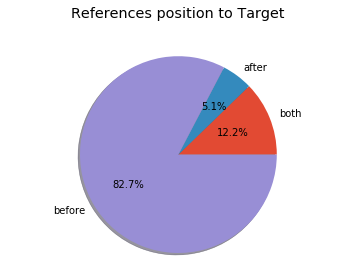

In [38]:
loc_c = Counter([target_before_after(x) for x in target_ref_tokens_order])

fig_agg, ax_agg = plt.subplots()

ax_agg.pie(loc_c.values(), labels=loc_c.keys(), autopct='%1.1f%%',
        shadow=True)
ax_agg.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('References position to Target', y=1.1)
# my_dpi=1200
# plt.savefig('../resources/cat-dist.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Total Tokens

In [39]:
sum([x['num_words'] for x in dataset.values()])

900777